# Redes Convolucionales con Pytorch

_Clasificación de imágenes_

<b>Objetivos:</b>
1. Clasifición de números con MNIST
2. Comparar una red fully connected con una Convolucional
3. Utilizar ResNet18 desde cero
4. Utilizar ResNet18 con Transfer Learning

<b>Paquetes a instalar:</b>
Pytorch, Torchvision, cudnn, cudatoolkit, matplotlib


In [1]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


## Dataset de MNIST
- Imágenes de 28x28 píxeles
- 60.000 imágenes de training
- 10.000 imágenes de test


In [2]:
# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 256
EPOCHS = 30
IMAGE_SIZE = 28
DATASET_DIR = 'data'
MODELS_DIR = 'models/'


Shape of X [N, C, H, W]: torch.Size([256, 1, 28, 28])
Shape of y: torch.Size([256]) torch.int64
Classes: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
Num classes: 10


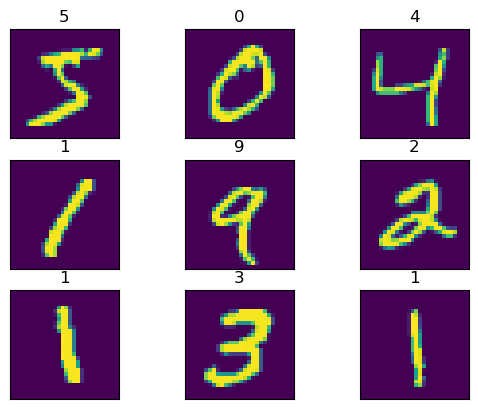

In [3]:
# Cargamos dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt

# importamos los conjuntos de training y test
training = datasets.MNIST(DATASET_DIR, train=True, download=True,
                          transform=ToTensor())
testing = datasets.MNIST(DATASET_DIR, train=False, download=True,
                      transform=ToTensor())

# creamos los Dataloader para cada conjunto
train_dataloader = DataLoader(training, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing, batch_size=BATCH_SIZE)

# estructura de los batches
X, y = next(iter(train_dataloader))
print(f"Shape of X [N, C, H, W]: {X.shape}")
print(f"Shape of y: {y.shape} {y.dtype}")

classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(testing.class_to_idx)
print('Classes:', testing.class_to_idx)
print('Num classes:', num_classes)

# mostramos las 9 primeras imágenes
i=1
for img,j in zip(X[:9],y[:9]):
    plt.subplot(3,3,i)
    plt.imshow(img.reshape((IMAGE_SIZE,IMAGE_SIZE)))
    plt.title(j.item())
    plt.xticks([])
    plt.yticks([])
    i+=1

## Entrenamiento con fully connected network
- Creación de una red con 2 capas ocultas
- Estructura: entrada 784, oculta1 512, oculta2 512, salida 10

In [4]:
# Definimos el modelo
from torch import nn
from torchinfo  import summary

# creamos la red feed-forward
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected,self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(IMAGE_SIZE*IMAGE_SIZE, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = FullyConnected().to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
FullyConnected (FullyConnected)          [256, 1, 28, 28]     [256, 10]            --                   True
├─Sequential (linear_relu_stack)         [256, 1, 28, 28]     [256, 10]            --                   True
│    └─Flatten (0)                       [256, 1, 28, 28]     [256, 784]           --                   --
│    └─Linear (1)                        [256, 784]           [256, 512]           401,920              True
│    └─ReLU (2)                          [256, 512]           [256, 512]           --                   --
│    └─Dropout (3)                       [256, 512]           [256, 512]           --                   --
│    └─Linear (4)                        [256, 512]           [256, 512]           262,656              True
│    └─ReLU (5)                          [256, 512]           [256, 512]           --                   --
│    └─Dropout (6)    

### Procedimientos de training y test

In [5]:
from torch import optim

# definimos la métrica y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer, losses, accuracy):
    size = len(dataloader.dataset)

    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            train_acc = 100*correct / size
            losses.append(loss.item())
            print(f"Accuracy: {train_acc:>0.1f}%, Avg loss: {loss.item():>8f} [{current:>5d}/{size:>5d}]")

    train_acc = 100*correct/size
    accuracy.append(train_acc)


# función de test
def test(dataloader, model, loss_fn, losses, accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_acc = 100*correct/size
    losses.append(test_loss)
    accuracy.append(test_acc)
    print(f"Test Error: \n Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Bucle principal para Fully Connected Network

In [6]:
# bucle de entranamiento
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")

torch.save(model.state_dict(), MODELS_DIR+"model_ff.pth")
print("Model saved model_ff.pth")


Epoch 1
-------------------------------
Accuracy: 0.0%, Avg loss: 2.297305 [  256/60000]
Accuracy: 34.9%, Avg loss: 0.293776 [25856/60000]
Accuracy: 73.9%, Avg loss: 0.194024 [51456/60000]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.162441 

Epoch 2
-------------------------------
Accuracy: 0.4%, Avg loss: 0.190518 [  256/60000]
Accuracy: 40.5%, Avg loss: 0.201099 [25856/60000]
Accuracy: 80.9%, Avg loss: 0.131477 [51456/60000]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.110697 

Epoch 3
-------------------------------
Accuracy: 0.4%, Avg loss: 0.131363 [  256/60000]
Accuracy: 41.2%, Avg loss: 0.136872 [25856/60000]
Accuracy: 82.2%, Avg loss: 0.131338 [51456/60000]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.094439 

Epoch 4
-------------------------------
Accuracy: 0.4%, Avg loss: 0.137764 [  256/60000]
Accuracy: 41.6%, Avg loss: 0.114121 [25856/60000]
Accuracy: 82.7%, Avg loss: 0.104590 [51456/60000]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.082577 

Epoch 5
----------------------------

### Gráficas de precisión y pérdida

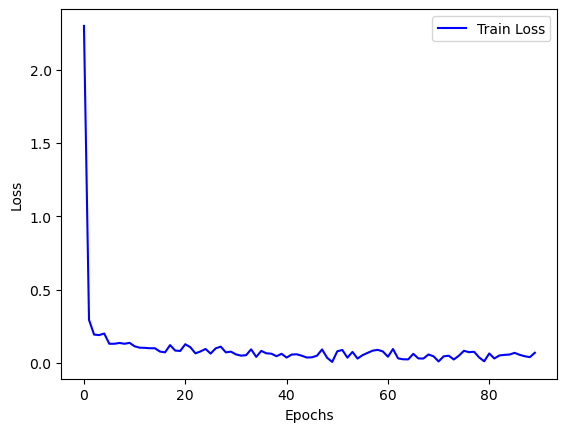

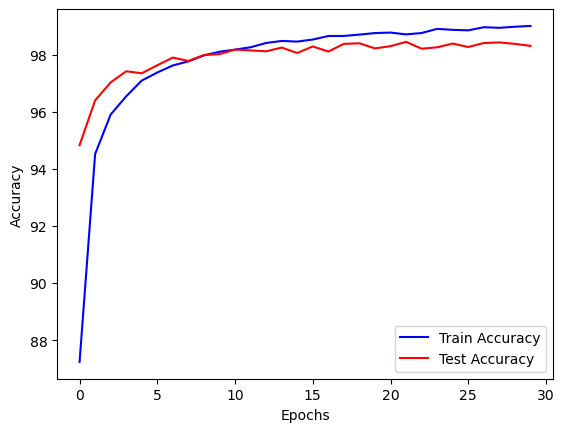

In [7]:
import matplotlib.pyplot as plt

def draw_graphics(train_loss, train_acc, test_acc):

    # Dibujamos las gráficas
    x = range(len(train_loss))
    plt.figure()
    plt.plot(x,train_loss, color='blue')
    plt.legend(['Train Loss'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('train_loss.svg')
    
    plt.figure()
    plt.plot(train_acc, color='blue')
    plt.plot(test_acc, color='red')
    plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('Accuracy.svg')
    
draw_graphics(train_loss, train_acc, test_acc)

### Visualización de dígitos mal clasificados

Numero elementos por digito: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Total: 10000


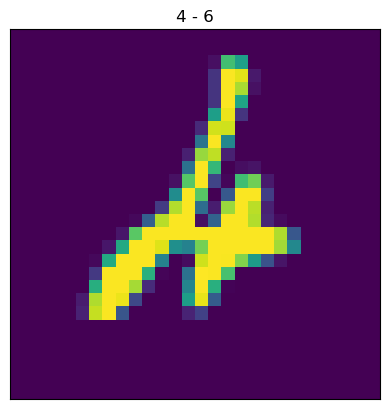

In [8]:
import numpy as np

# Función para buscar incorrectos y dibujarlos
def draw_incorrect(model, dataloader, num=3):
    for i in range(num):
        X, y = next(iter(dataloader))
        X, y = X.to(device), y.to(device)
        model.to(device)
        pred = model(X)
        incorrect = (pred.argmax(1) != y)
        for img,l,d in zip(X[incorrect],y[incorrect],pred[incorrect].argmax(1)):
            img, l = img.to('cpu'), l.to('cpu')
            plt.imshow(img.reshape((IMAGE_SIZE,IMAGE_SIZE)))
            plt.title(f"{l.item()} - {d.item()}")
            plt.xticks([])
            plt.yticks([])
        
# Contamos el número de elementos que hay de cada dígito
count = np.zeros(10, np.int32)
for _,y in test_dataloader:
    np.add.at(count, y, 1)

print("Numero elementos por digito:", count)
print("Total:", count.sum())

draw_incorrect(model, test_dataloader)



## Entrenamiento con redes convolucionales simples

### ConvNet1
- 2 Bloques Convolucionales
- 1 Fully-connected

### ConvNet2
- 2 Bloques Convolucionales
- 1 Fully-connected
- BatchNormalization

### ConvNet3
- 3 Bloques Convolucionales
- 1 Fully-connected
- BatchNormalization


In [9]:
# Definimos las redes convolucionales
from torch import nn
from torchinfo import summary

def bloque_conv(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

def bloque_conv_norm(in_features, out_features):
    return nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, 1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = bloque_conv(1, 32)
        self.conv2 = bloque_conv(32, 64)
        self.linear_out = nn.Sequential(
            #nn.Dropout(0.25),
            nn.Flatten(),
            #nn.Linear(1600, 128),
            #nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(1600, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        logits = self.linear_out(x)
        return logits

    
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = bloque_conv_norm(1, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1600, 10),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        logits = self.linear_out(x)
        return logits


class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = bloque_conv_norm(1, 32)
        self.conv2 = bloque_conv_norm(32, 64)
        self.conv3 = bloque_conv_norm(64, 128)
        self.linear_out = nn.Sequential(
            nn.Flatten(),
            #nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        logits = self.linear_out(x)
        return logits


In [10]:
# creamos el modelo
model = ConvNet3() #ConvNet1 #ConvNet2
model.to(device)

summary(model,
        input_size=(BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ConvNet3 (ConvNet3)                      [256, 1, 28, 28]     [256, 10]            --                   True
├─Sequential (conv1)                     [256, 1, 28, 28]     [256, 32, 13, 13]    --                   True
│    └─Conv2d (0)                        [256, 1, 28, 28]     [256, 32, 26, 26]    320                  True
│    └─BatchNorm2d (1)                   [256, 32, 26, 26]    [256, 32, 26, 26]    64                   True
│    └─ReLU (2)                          [256, 32, 26, 26]    [256, 32, 26, 26]    --                   --
│    └─MaxPool2d (3)                     [256, 32, 26, 26]    [256, 32, 13, 13]    --                   --
├─Sequential (conv2)                     [256, 32, 13, 13]    [256, 64, 5, 5]      --                   True
│    └─Conv2d (0)                        [256, 32, 13, 13]    [256, 64, 11, 11]    18,496               True
│    └─BatchNorm2d

In [11]:
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# bucle principal
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}/{EPOCHS}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)

print("Done!")

torch.save(model.state_dict(), MODELS_DIR+"model_cnn1.pth")
print("Model saved model_cnn1.pth")


Epoch 1/30
-------------------------------
Accuracy: 0.0%, Avg loss: 2.480028 [  256/60000]
Accuracy: 40.0%, Avg loss: 0.081508 [25856/60000]
Accuracy: 81.6%, Avg loss: 0.092439 [51456/60000]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.069216 

Epoch 2/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.070861 [  256/60000]
Accuracy: 42.2%, Avg loss: 0.064337 [25856/60000]
Accuracy: 84.2%, Avg loss: 0.031909 [51456/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.060478 

Epoch 3/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.054861 [  256/60000]
Accuracy: 42.5%, Avg loss: 0.061573 [25856/60000]
Accuracy: 84.7%, Avg loss: 0.033806 [51456/60000]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.045851 

Epoch 4/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.049347 [  256/60000]
Accuracy: 42.7%, Avg loss: 0.039555 [25856/60000]
Accuracy: 85.1%, Avg loss: 0.043708 [51456/60000]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.064363 

Epoch 5/30
-------------

0.02966751530766487
99.65333333333334
98.62


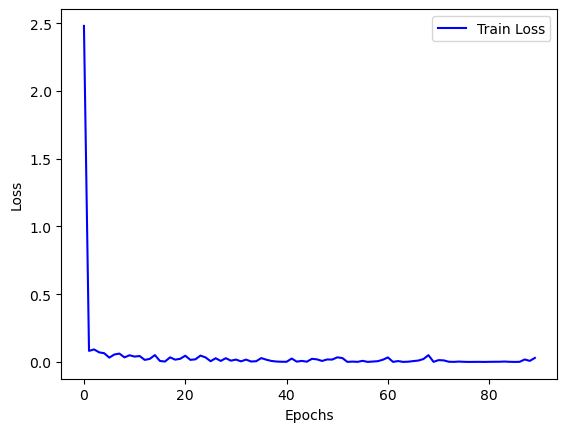

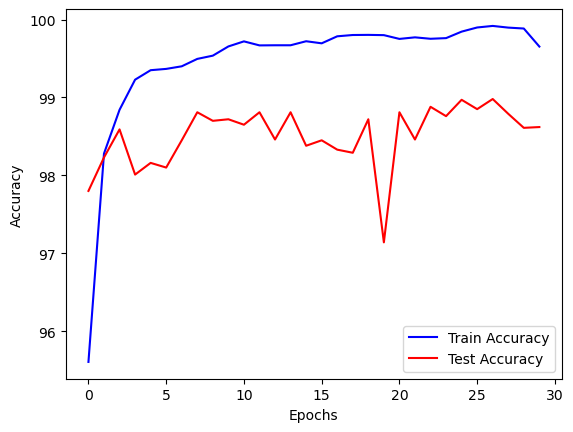

In [12]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)

## Entrenamiento con ResNet18 desde Cero


In [13]:
from torchvision.models import resnet18
from torchvision.transforms import Grayscale, ToTensor

model = resnet18()

transform = Compose([
    Grayscale(num_output_channels=3),
    ToTensor()
])

training = datasets.MNIST('data', train=True, download=True,
                          transform=transform )
testing = datasets.MNIST('data', train=False, download=True,
                      transform=transform)

train_dataloader = DataLoader(training, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing, batch_size=BATCH_SIZE)


# Cambiamos la capa superior con una capa Lineal con el número de clases
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True),
    torch.nn.Linear(in_features=num_features,
                    out_features=num_classes,
                    bias=True)).to(device)

summary(model,
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [256, 3, 28, 28]     [256, 10]            --                   True
├─Conv2d (conv1)                         [256, 3, 28, 28]     [256, 64, 14, 14]    9,408                True
├─BatchNorm2d (bn1)                      [256, 64, 14, 14]    [256, 64, 14, 14]    128                  True
├─ReLU (relu)                            [256, 64, 14, 14]    [256, 64, 14, 14]    --                   --
├─MaxPool2d (maxpool)                    [256, 64, 14, 14]    [256, 64, 7, 7]      --                   --
├─Sequential (layer1)                    [256, 64, 7, 7]      [256, 64, 7, 7]      --                   True
│    └─BasicBlock (0)                    [256, 64, 7, 7]      [256, 64, 7, 7]      --                   True
│    │    └─Conv2d (conv1)               [256, 64, 7, 7]      [256, 64, 7, 7]      36,864               True
│    │    └─BatchN

In [14]:
# train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = EPOCHS
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Done!")

torch.save(model.state_dict(), MODELS_DIR+"model_resnet.pth")
print("Model saved to model_resnet.pth")

Epoch 1/30
-------------------------------
Accuracy: 0.0%, Avg loss: 2.633709 [  256/60000]
Accuracy: 40.4%, Avg loss: 0.120509 [25856/60000]
Accuracy: 81.9%, Avg loss: 0.103388 [51456/60000]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.060298 

Epoch 2/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.049921 [  256/60000]
Accuracy: 42.4%, Avg loss: 0.033252 [25856/60000]
Accuracy: 84.3%, Avg loss: 0.051520 [51456/60000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.097207 

Epoch 3/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.042082 [  256/60000]
Accuracy: 42.6%, Avg loss: 0.014878 [25856/60000]
Accuracy: 84.8%, Avg loss: 0.042452 [51456/60000]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.079508 

Epoch 4/30
-------------------------------
Accuracy: 0.4%, Avg loss: 0.050413 [  256/60000]
Accuracy: 42.7%, Avg loss: 0.022281 [25856/60000]
Accuracy: 84.9%, Avg loss: 0.023857 [51456/60000]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.068142 

Epoch 5/30
-------------

0.004857460502535105
99.805
99.2


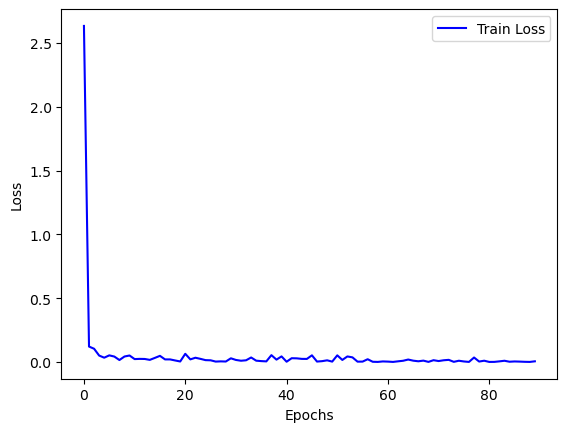

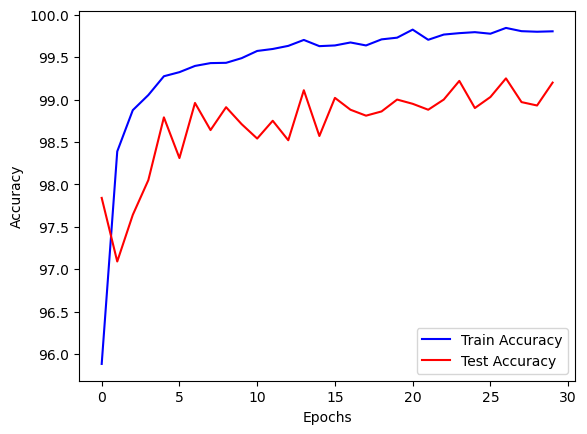

In [15]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)

## Entrenamiento con ResNet18 y Transfer Learning



In [16]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Grayscale
import numpy as np

# Instanciamos el modelo ResNet18 con los pesos por defecto
weights=ResNet18_Weights.DEFAULT
auto_transforms = weights.transforms()

# Cargamos el dataset con las transformaciones originales
transform=Compose([
    Grayscale(num_output_channels=3),
    auto_transforms,
])

training = datasets.MNIST('data', train=True, download=True,
                          transform=transform)
testing = datasets.MNIST('data', train=False, download=True,
                      transform=transform)

# Seleccionamos un subconjunto de imágenes de entrenamiento 
reduced_training = Subset(training, range(2500))

train_dataloader = DataLoader(reduced_training, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(testing, batch_size=BATCH_SIZE)

# Estructura de los batches
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Creamos el modelo y congelamos parámetros de la red
model = resnet18(weights=weights).to(device)
for name, para in model.named_parameters():
    para.requires_grad = False

# Cambiamos la capa superior con una capa Lineal con 10 clases de salida
num_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=num_features,
                    out_features=num_classes,
                    bias=True).to(device)

summary(model,
        input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Shape of X [N, C, H, W]: torch.Size([256, 3, 224, 224])
Shape of y: torch.Size([256]) torch.int64


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\adria/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [256, 3, 28, 28]     [256, 10]            --                   Partial
├─Conv2d (conv1)                         [256, 3, 28, 28]     [256, 64, 14, 14]    (9,408)              False
├─BatchNorm2d (bn1)                      [256, 64, 14, 14]    [256, 64, 14, 14]    (128)                False
├─ReLU (relu)                            [256, 64, 14, 14]    [256, 64, 14, 14]    --                   --
├─MaxPool2d (maxpool)                    [256, 64, 14, 14]    [256, 64, 7, 7]      --                   --
├─Sequential (layer1)                    [256, 64, 7, 7]      [256, 64, 7, 7]      --                   False
│    └─BasicBlock (0)                    [256, 64, 7, 7]      [256, 64, 7, 7]      --                   False
│    │    └─Conv2d (conv1)               [256, 64, 7, 7]      [256, 64, 7, 7]      (36,864)             False
│    │    

In [17]:
# train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = EPOCHS
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Done!")

torch.save(model.state_dict(), MODELS_DIR+"model_resnet_tl1.pth")
print("Model saved to model_resnet_tl1.pth")



Epoch 1/30
-------------------------------
Accuracy: 0.8%, Avg loss: 2.417216 [  256/ 2500]
Test Error: 
 Accuracy: 41.7%, Avg loss: 1.655078 

Epoch 2/30
-------------------------------
Accuracy: 5.6%, Avg loss: 1.160788 [  256/ 2500]
Test Error: 
 Accuracy: 58.1%, Avg loss: 1.331621 

Epoch 3/30
-------------------------------
Accuracy: 8.6%, Avg loss: 0.601863 [  256/ 2500]
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.997311 

Epoch 4/30
-------------------------------
Accuracy: 9.1%, Avg loss: 0.413681 [  256/ 2500]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.676837 

Epoch 5/30
-------------------------------
Accuracy: 9.4%, Avg loss: 0.303076 [  256/ 2500]
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.597014 

Epoch 6/30
-------------------------------
Accuracy: 9.5%, Avg loss: 0.282684 [  256/ 2500]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.408792 

Epoch 7/30
-------------------------------
Accuracy: 9.6%, Avg loss: 0.244101 [  256/ 2500]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.3

0.06282255053520203
99.72
93.26


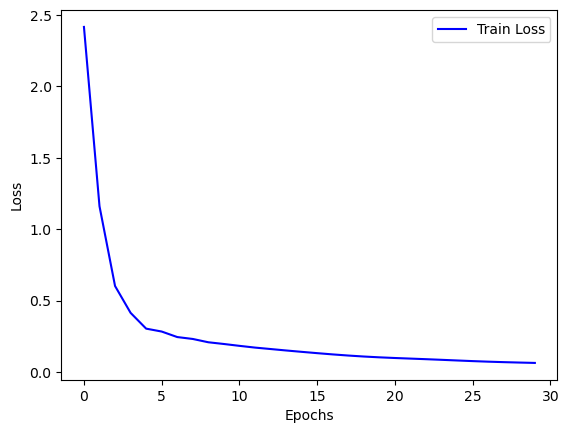

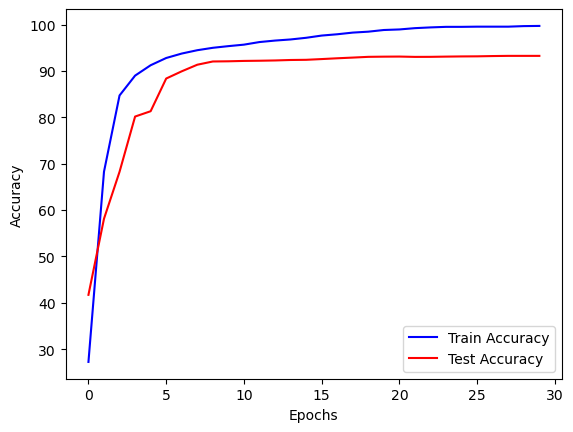

In [18]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)

### Mejoramos el resultado entrenando la red completa

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for name, para in model.named_parameters():
    para.requires_grad = True

train_loss = []
test_loss = []
train_acc = []
test_acc = []
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss, train_acc)
    test(test_dataloader, model, loss_fn, test_loss, test_acc)
print("Done!")

torch.save(model.state_dict(), MODELS_DIR+"model_resnet_tl2.pth")
print("Model saved to model_resnet_tl2.pth")


Epoch 1/10
-------------------------------
Accuracy: 10.2%, Avg loss: 0.060332 [  256/ 2500]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.261710 

Epoch 2/10
-------------------------------
Accuracy: 10.2%, Avg loss: 0.002418 [  256/ 2500]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.130694 

Epoch 3/10
-------------------------------
Accuracy: 10.2%, Avg loss: 0.001122 [  256/ 2500]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.084325 

Epoch 4/10
-------------------------------
Accuracy: 10.2%, Avg loss: 0.001314 [  256/ 2500]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.068486 

Epoch 5/10
-------------------------------
Accuracy: 10.2%, Avg loss: 0.000747 [  256/ 2500]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.063183 

Epoch 6/10
-------------------------------
Accuracy: 10.2%, Avg loss: 0.000451 [  256/ 2500]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.061361 

Epoch 7/10
-------------------------------
Accuracy: 10.2%, Avg loss: 0.000310 [  256/ 2500]
Test Error: 
 Accuracy: 98.1%, Avg lo

0.000156502312165685
100.0
98.16


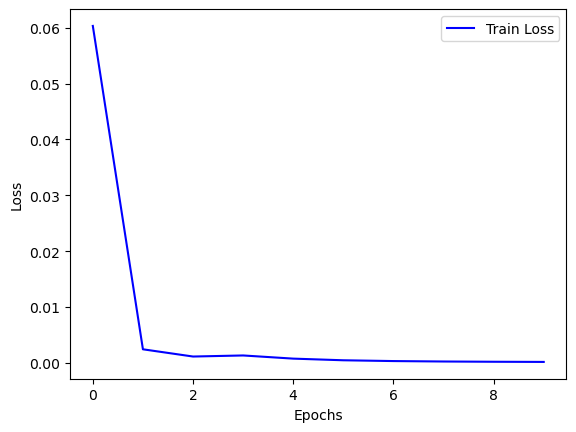

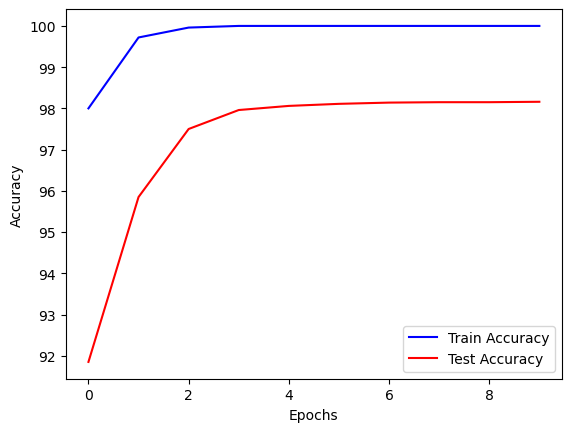

In [20]:
print(train_loss[-1])
print(train_acc[-1])
print(test_acc[-1])

draw_graphics(train_loss, train_acc, test_acc)